## Build features for modeling

### Load data


In [8]:
from activity_tracker import utils
import sqlite3
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data loading
data_dir = pathlib.Path("../data")
db_path = data_dir / "sqlite" / "analysis.db"
mapper_path = data_dir / "data_mapper.yml"
conn = sqlite3.connect(db_path)
mapping_dict = utils.load_data_mapper(mapper_path)

df_subject = pd.read_sql_query("SELECT * FROM subject", conn)
df_visit = pd.read_sql_query("SELECT * FROM visit", conn)
df_measurement = pd.read_sql_query("SELECT * FROM daily_measurement", conn)

In [38]:
# # store each to csv
# df_subject.to_csv("../data/train/subject.csv", index=False)
# df_visit.to_csv("../data/train/visit.csv", index=False)
# df_measurement.to_csv("../data/train/daily_measurement.csv", index=False)

### Build features



In [75]:
# Add prev visit date and ffp status binary
df_visit.sort_values(["subject_id", "visit_id"])
df_visit["prev_visit_date"] = df_visit.groupby("subject_id")["date"].shift(1)
df_visit["prev_ffp_status_binary"] = df_visit.groupby("subject_id")["ffp_status_binary"].shift(1)
df_visit['date'] = pd.to_datetime(df_visit['date'])
df_visit['days_since_prev_visit'] = df_visit.groupby('subject_id')['date'].diff().dt.days

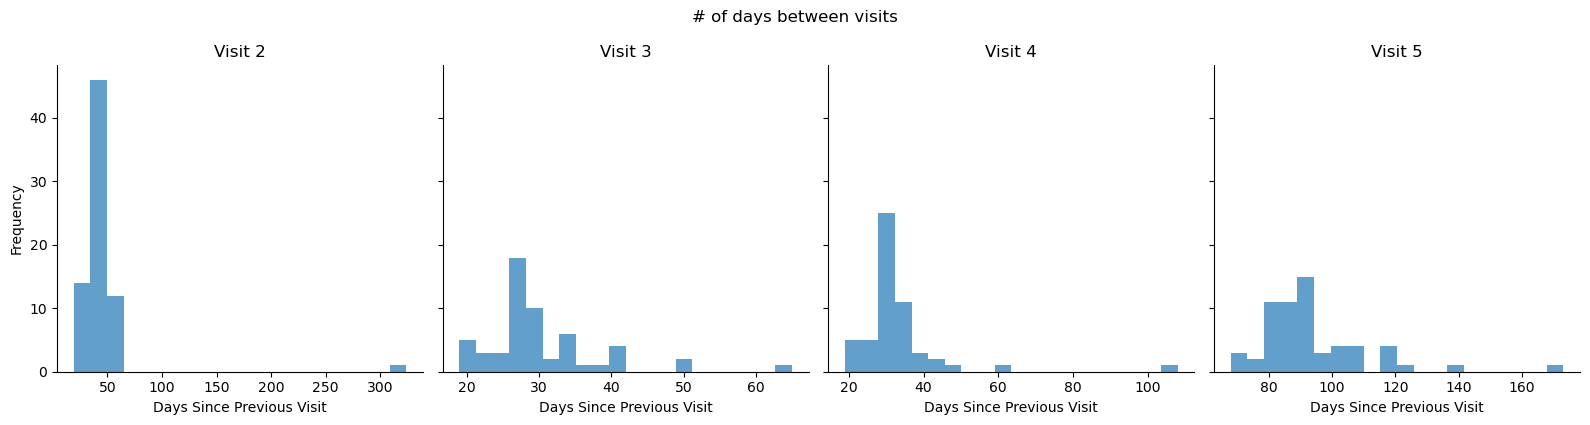

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

visit_ids = sorted([v for v in df_visit['visit_id'].unique() if v != 1])
n_visits = len(visit_ids)

fig, axes = plt.subplots(1, n_visits, figsize=(4 * n_visits, 4), sharey=True)

for i, visit_id in enumerate(visit_ids):
    ax = axes[i]
    group = df_visit[df_visit['visit_id'] == visit_id]
    ax.hist(group['days_since_prev_visit'].dropna(), bins=20, alpha=0.7)
    ax.set_title(f'Visit {visit_id}')
    ax.set_xlabel('Days Since Previous Visit')
    sns.despine(ax=ax)
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('# of days between visits', y=1.05)
plt.show()